# Analysis of repeated injections of the same sample

In [1]:
import os
import glycoproteomics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
from pprint import pprint
matplotlib_inline.backend_inline.set_matplotlib_formats("png")
figure_size = (8, 4)
dpi = 100

spectra_directory = "/Users/jonesm5/Dropbox (The Francis Crick)/Serum_RepInj"

Read in all spectra from folder:

In [2]:
spectra = glycoproteomics.io.read_spectra_directory(spectra_directory)
pprint(list(spectra.keys()))

['20210616_serum_repinj_2.5ug_10.wiff.dia.extracted.txt',
 '20210616_serum_repinj_2.5ug_4.wiff.dia.extracted.txt',
 '20210616_serum_repinj_2.5ug_9.wiff.dia.extracted.txt',
 '20210616_serum_repinj_2.5ug_3.wiff.dia.extracted.txt',
 '20210616_serum_repinj_2.5ug_7.wiff.dia.extracted.txt',
 '20210616_serum_repinj_2.5ug_6.wiff.dia.extracted.txt',
 '20210616_serum_repinj_2.5ug_1.wiff.dia.extracted.txt',
 '20210616_serum_repinj_2.5ug_2.wiff.dia.extracted.txt',
 '20210616_serum_repinj_2.5ug_8.wiff.dia.extracted.txt',
 '20210616_serum_repinj_2.5ug_5.wiff.dia.extracted.txt']


Bin the spectra to make them easier to work with and merge

In [3]:
rt_x_bin_size = 0.06
mz_y_bin_size = 2.0

binned_spectra = {
    name: glycoproteomics.spectrum.bin(
        spectrum,
        rt_x_bin_size,
        mz_y_bin_size,
        np.mean)
    for name, spectrum in spectra.items()
}
del(spectra)

Merge the spectra and plot the resulting merged spectrum.

In [4]:

merged_spectrum = glycoproteomics.spectrum.combine(binned_spectra, np.sum)
ions = glycoproteomics.spectrum.list_ions(merged_spectrum)
print(ions)

['366.14']


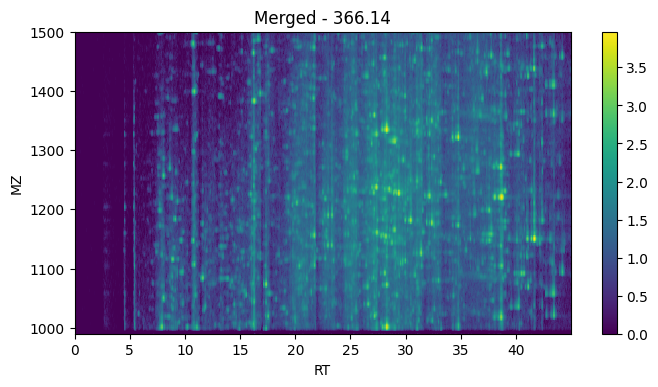

In [5]:
ion = ions[0]
merged_ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(merged_spectrum, ion)
glycoproteomics.plotting.plot_ion_matrix(
    merged_ion_matrix,
    x_label,
    y_label,
    "Merged - " + ion,
    figure_size,
    dpi
)
plt.show()

Calling the top 100 peaks from this file

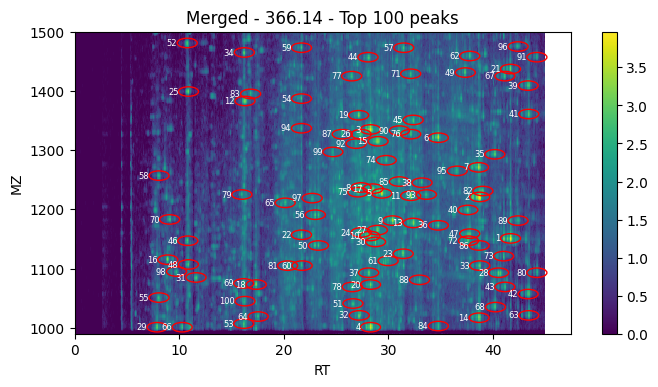

In [6]:
top_N_peaks = 100
x_radius = rt_x_bin_size * 16.0
y_radius = mz_y_bin_size * 4.0

peaks = glycoproteomics.peaks.find(
    merged_ion_matrix,
    x_label,
    y_label,
    top_N_peaks,
    x_radius,
    y_radius
)

glycoproteomics.plotting.plot_ion_matrix_with_peaks(
    merged_ion_matrix,
    x_label,
    y_label,
    peaks,
    x_radius,
    y_radius,
    "Merged - " + ion + " - Top {} peaks".format(top_N_peaks),
    figure_size,
    dpi
)
plt.show()

For each spectra, return the maximum value for each peak and plot the spectra.

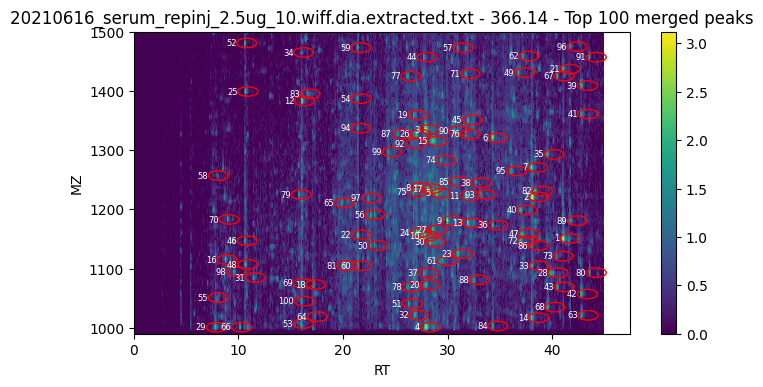

[1317.08, 1212.68, 985.852, 645.89525, 571.8115]


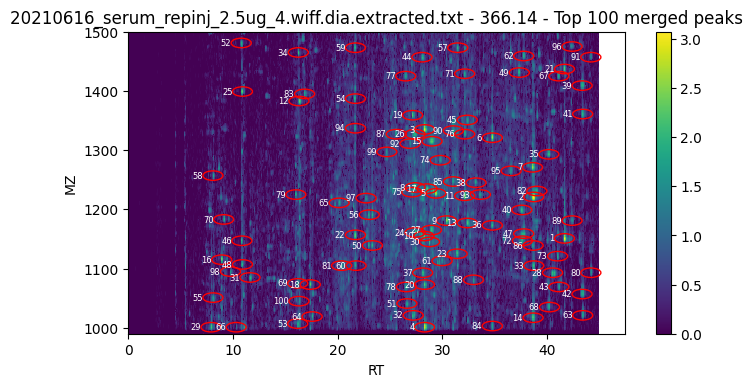

[1155.65, 1186.25, 976.27475, 722.3905, 486.7745]


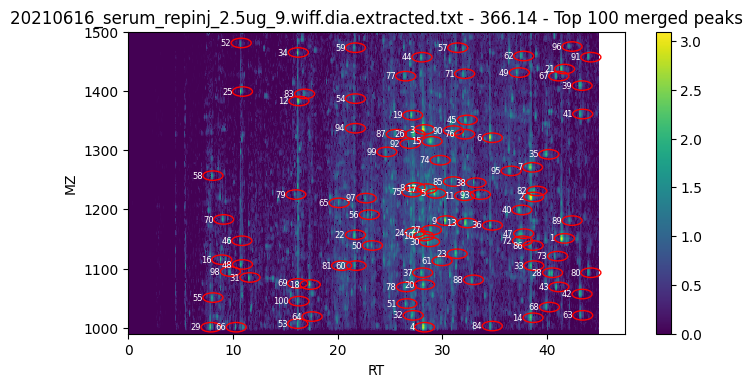

[1243.115, 1130.9450000000002, 1035.2350000000001, 693.338, 611.5419999999999]


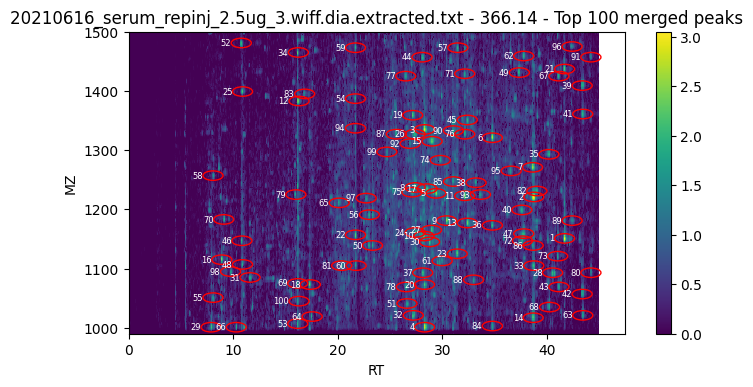

[1118.995, 1081.505, 909.25225, 681.371, 525.7075]


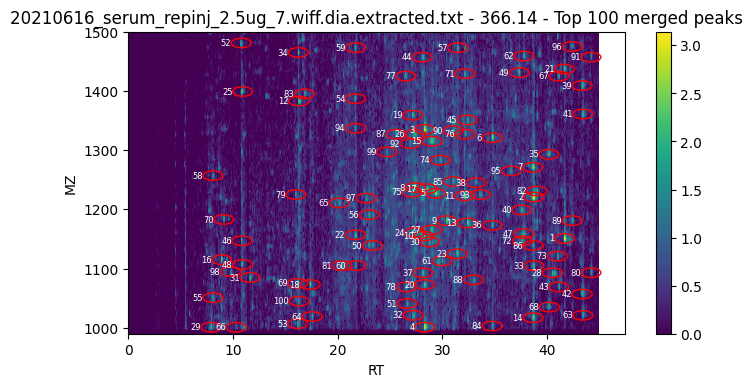

[1385.06, 1074.04, 942.06, 701.9304999999999, 462.72025]


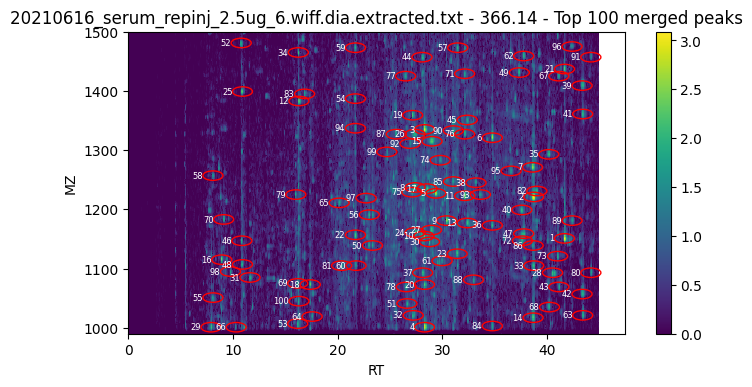

[1227.51, 1094.49, 956.93575, 719.267, 524.3065]


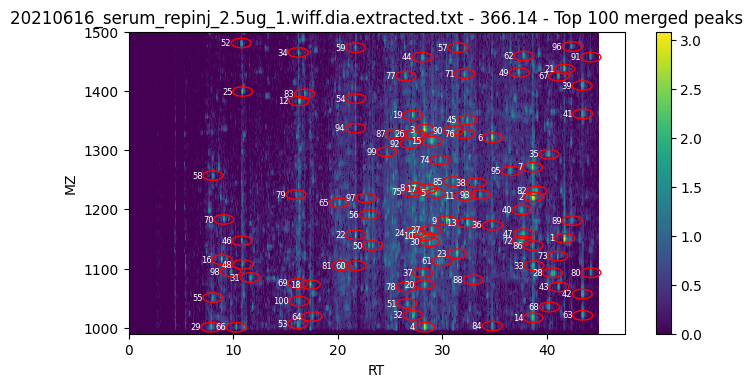

[1216.885, 1125.29, 845.2675, 681.425, 573.8975]


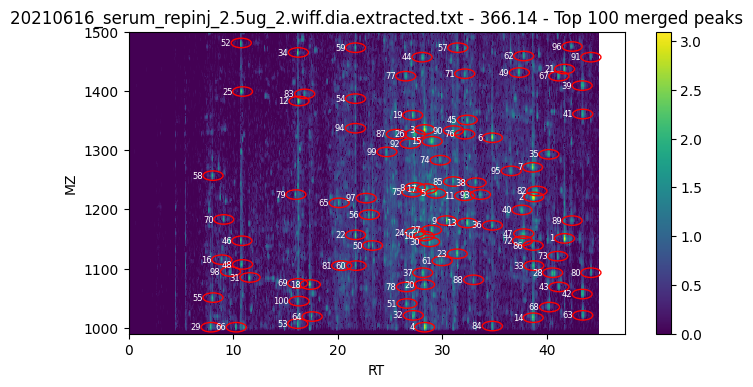

[1242.3600000000001, 1142.685, 932.7835, 674.083, 580.1610000000001]


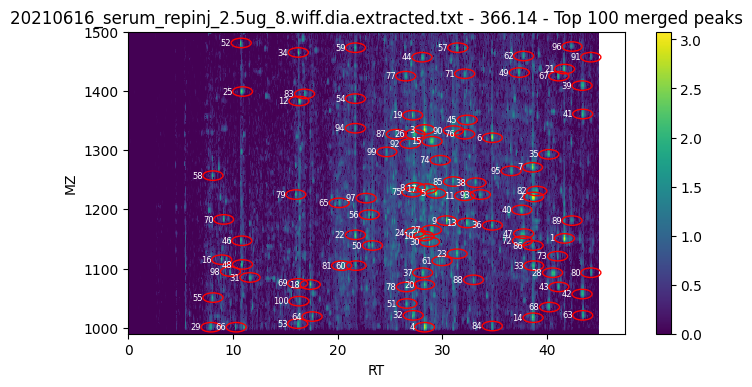

[1066.4850000000001, 1196.28, 937.7407499999999, 654.444, 552.8025]


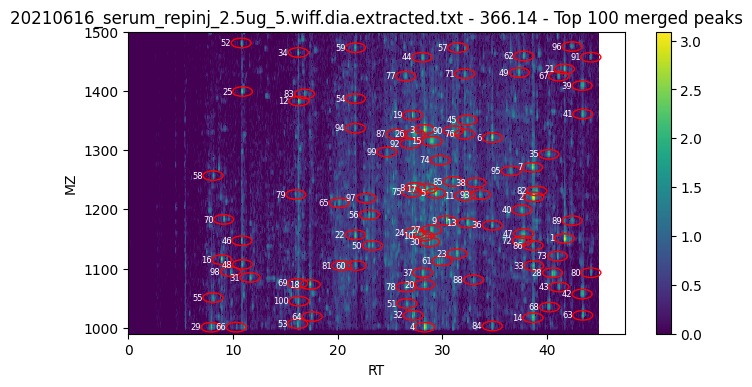

[1232.3000000000002, 1158.63, 969.7117499999999, 726.4485, 559.735]


In [7]:
peak_value_dict = {}
for name, spectrum in binned_spectra.items():
    ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(spectrum, ion)
    # Plot the individual spectrum with the merged peaks
    glycoproteomics.plotting.plot_ion_matrix_with_peaks(
        ion_matrix,
        x_label,
        y_label,
        peaks,
        x_radius,
        y_radius,
        "{} - ".format(name) + ion + " - Top {} merged peaks".format(top_N_peaks),
        figure_size,
        dpi
    )
    plt.show()
    # Determine the maximum value within the peak ellipse for each peak
    peak_values = glycoproteomics.peaks.integrate(
        ion_matrix, x_label, y_label, peaks, x_radius, y_radius, np.max
    )
    peak_value_dict[name] = peak_values
    # Print the top 5 peaks
    print(peak_values[:5])


Save the maximum peak values to a separate file.

In [8]:
with open("repeat_injection_peaks.tsv", "w") as out_f:
    out_f.write("\t".join(["spectrum_name"] +
        ["peak_{}".format(i+1) for i in range(top_N_peaks)]) + "\n")
    for name, peak_values in peak_value_dict.items():
        out_f.write("\t".join([name] + ["{}".format(i) for i in peak_values]) + "\n")

The individual spectra show that there is RT drifting at larger RT values. This can be corrected by using dynamic time warping (DTW). The implementation here can result in column duplication, which isn't great for integration, so should be used carefully. I recommend aligning the spectra prior to merging, to allow clean peaks to be called. Then use the DTW RT mappings to move the peaks for each peak prior to integration.

Peaks have to be aligned to a reference, which here is chosen to be the first sample.

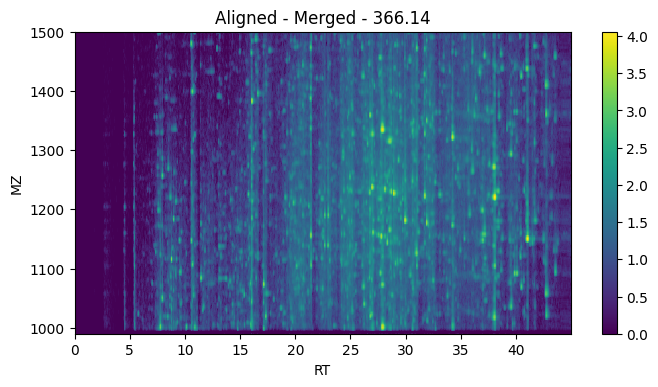

In [9]:
ref_name = list(binned_spectra.keys())[0]

binned_aligned_spectra = {}
rt_alignment_mappings = {}
for name, spectra in binned_spectra.items():
    aligned_spectra, rt_alignment = glycoproteomics.spectrum.align_rt(
        spectra,
        binned_spectra[ref_name],
        1
    )
    binned_aligned_spectra[name] = aligned_spectra
    rt_alignment_mappings[name] = rt_alignment

merged_spectrum = glycoproteomics.spectrum.combine(binned_aligned_spectra, np.sum)
merged_ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(merged_spectrum, ion)
glycoproteomics.plotting.plot_ion_matrix(
    merged_ion_matrix,
    x_label,
    y_label,
    "Aligned - Merged - " + ion,
    figure_size,
    dpi
)
plt.show()

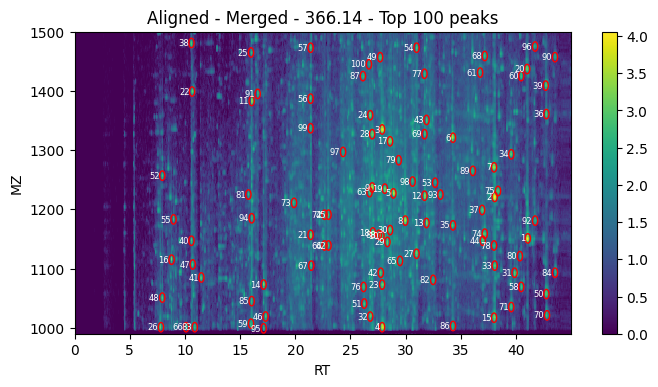

In [10]:
top_N_peaks = 100
x_radius = rt_x_bin_size * 4.0
y_radius = mz_y_bin_size * 4.0

peaks = glycoproteomics.peaks.find(
    merged_ion_matrix,
    x_label,
    y_label,
    top_N_peaks,
    x_radius,
    y_radius
)

glycoproteomics.plotting.plot_ion_matrix_with_peaks(
    merged_ion_matrix,
    x_label,
    y_label,
    peaks,
    x_radius,
    y_radius,
    "Aligned - Merged - " + ion + " - Top {} peaks".format(top_N_peaks),
    figure_size,
    dpi
)
plt.show()

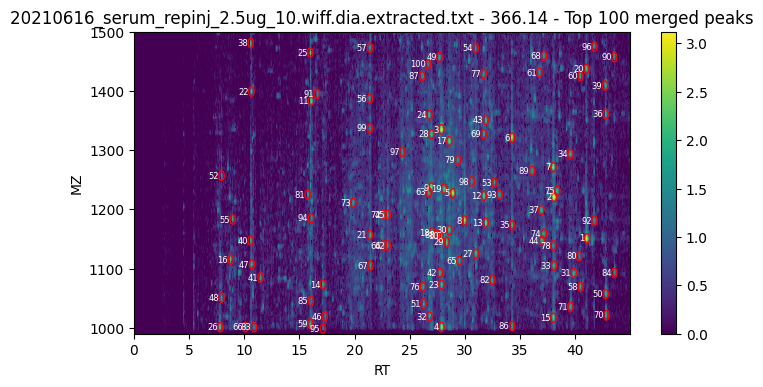

[12296.822243999999, 12853.2627875, 11208.115315, 6218.4410474999995, 5959.108737500001]


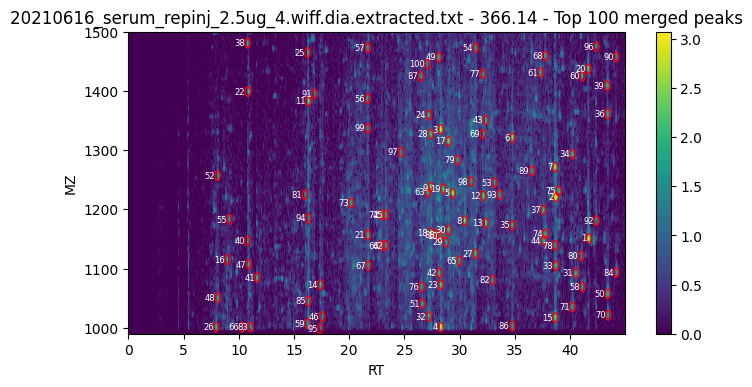

[10650.186845, 12727.22536, 9566.5445625, 7256.893905, 4436.890740000001]


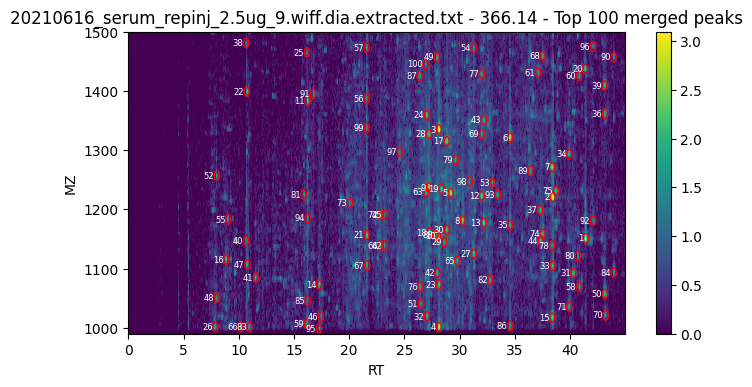

[10113.714387499998, 12251.609115000001, 12470.656837499999, 6572.401817499999, 5546.75258]


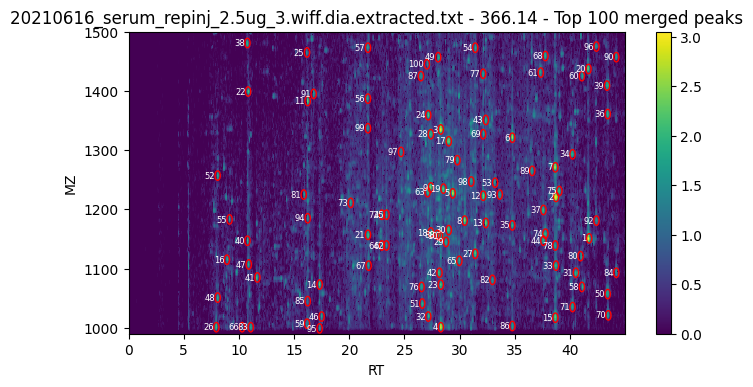

[9957.705755250001, 12259.1338275, 9599.839507499999, 6679.4582675, 4459.7934525]


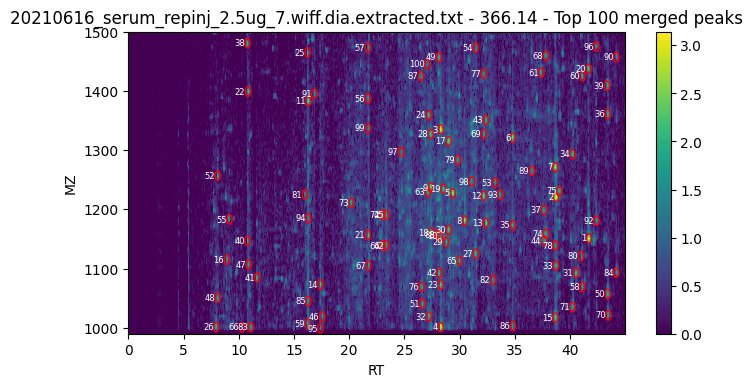

[11328.74608025, 11469.4136175, 9372.429035, 7382.812804500001, 4335.247997500001]


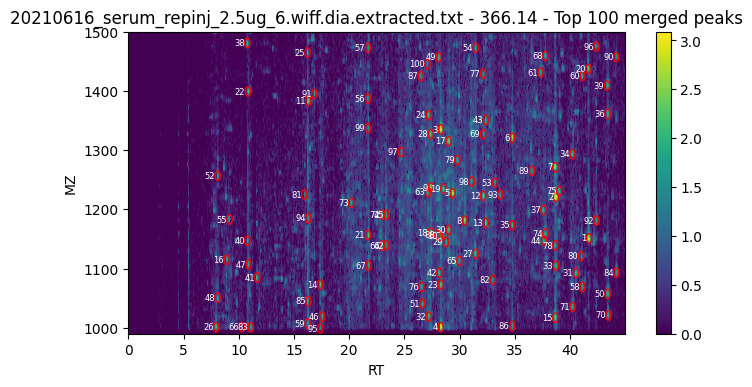

[10976.28036275, 12533.211607500001, 9198.512905, 7146.4973775, 4516.5995675]


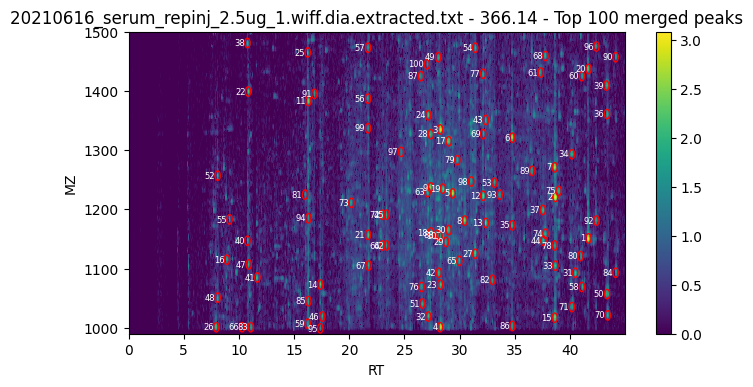

[10774.82379375, 12329.831742499999, 9352.53708, 6408.575585, 4578.42736]


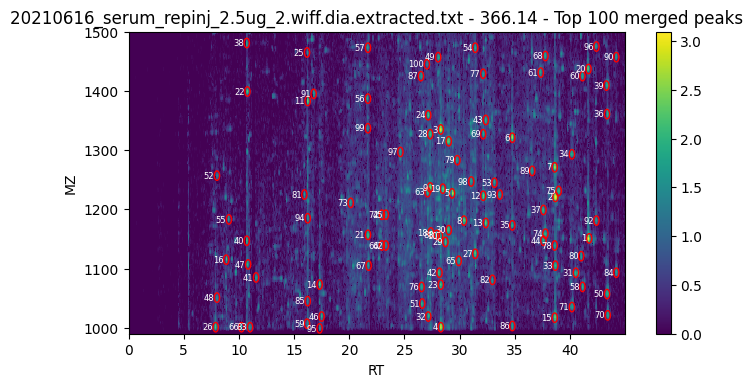

[10323.44189, 12022.4165975, 9568.52322, 7073.088905, 5085.162322500001]


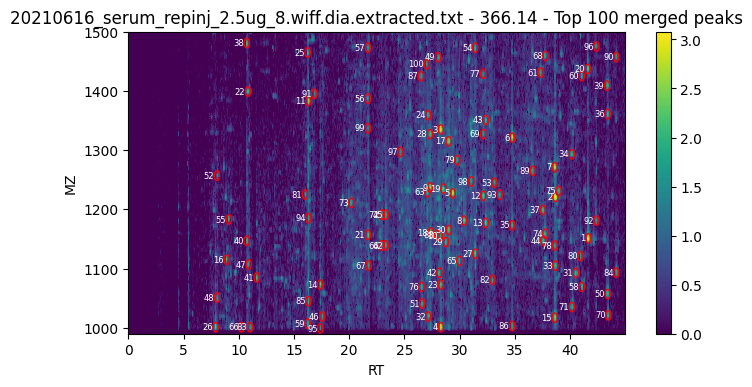

[10365.991298249999, 12879.147109999998, 9933.181209999999, 6815.0210675, 4442.76553]


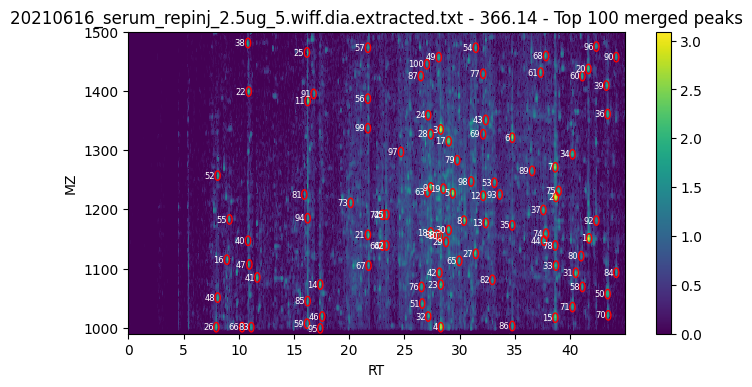

[11134.6325655, 12713.5787175, 9989.234642500001, 7147.632755, 4645.0936675]


In [11]:
aligned_peak_value_dict = {}
for name, spectrum in binned_spectra.items():
    ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(spectrum, ion)
    moved_peaks = glycoproteomics.peaks.rt_move(peaks, rt_alignment_mappings[name])
    # Plot the individual spectrum with the merged peaks
    glycoproteomics.plotting.plot_ion_matrix_with_peaks(
        ion_matrix,
        x_label,
        y_label,
        moved_peaks,
        x_radius,
        y_radius,
        "{} - ".format(name) + ion + " - Top {} merged peaks".format(top_N_peaks),
        figure_size,
        dpi
    )
    plt.show()
    # Determine the maximum value within the peak ellipse for each peak
    peak_values = glycoproteomics.peaks.integrate(
        ion_matrix, x_label, y_label, moved_peaks, x_radius, y_radius, np.sum
    )
    aligned_peak_value_dict[name] = peak_values
    # Print the top 5 peaks
    print(peak_values[:5])


Save the peaks to a separate file.

In [12]:
with open("repeat_injection_aligned_peaks.tsv", "w") as out_f:
    out_f.write("\t".join(["spectrum_name"] +
        ["peak_{}".format(i+1) for i in range(top_N_peaks)]) + "\n")
    for name, peak_values in aligned_peak_value_dict.items():
        out_f.write("\t".join([name] + ["{}".format(i) for i in peak_values]) + "\n")